In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from datetime import datetime

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [7]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
print(columns)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)


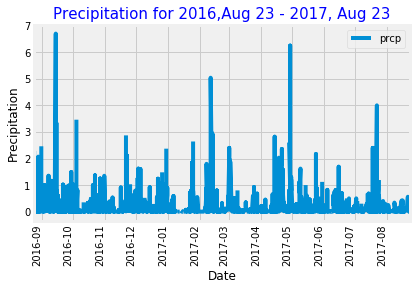

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
print(last)
y = int(last[2]+last[3]+last[4]+last[5])
m = int(last[7]+last[8])
d = int(last[10]+last[11])
start = dt.date(y,m,d)
# print(start)
# Calculate the date 1 year ago from the last data point in the database
query_date = start - dt.timedelta(days=365)
# print(query_date)
# Perform a query to retrieve the data and precipitation scores
precipitation = []
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > query_date).filter(Measurement.date <= 'last_date').\
                all()
# print(precipitation)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation)
df['date'] = pd.to_datetime(df['date'])
prcp_df = df.set_index('date')
prcp_df.head()
# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
#prcp_df.plot.bar(figsize = (15,8), sort_columns=True, use_index = True, legend = True)
prcp_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title("Precipitation for 2016,Aug 23 - 2017, Aug 23", fontsize = 15, color = 'b')
plt.savefig('Precipitation')
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
        filter(Measurement.station==Station.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.tobs,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
active = session.query(*sel).\
    filter(Measurement.station==Station.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
print(active)
station = session.query(Measurement.station, Station.name ).\
    filter(Measurement.station==Station.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
print(station)

(85.0, 54.0, 85.0, 71.66378066378067)
('USC00519281', 'WAIHEE 837.5, HI US')


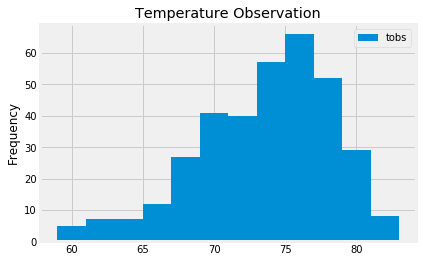

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station==station[0]).\
        filter(Measurement.date > query_date).filter(Measurement.date <= 'last_date').all()
#print(temp_obs)
hist = pd.DataFrame(temp_obs)
hist['date'] = pd.to_datetime(hist['date'])
hist.head()
temp = hist['tobs']
plt.hist(temp, bins=12)
plt.title("Temperature Observation")
plt.ylabel('Frequency')
plt.legend(labels = ['tobs'])
plt.savefig('Temperature Observation')

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip dates
my_start = '2017-04-04'
my_end = '2017-04-14'
my_trip_temps = calc_temps(my_start, my_end)
print(my_trip_temps)

[(67.0, 74.35211267605634, 82.0)]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


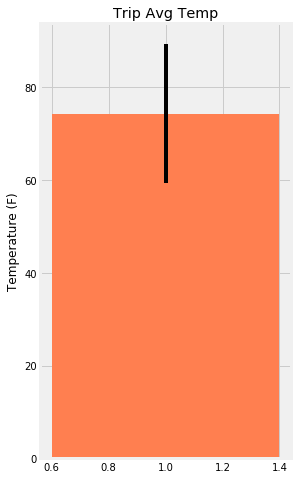

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
peak = my_trip_temps[0][2] - my_trip_temps[0][0]
bar = ax.bar(1, my_trip_temps[0][1], yerr = peak, color = "coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.savefig('my_trip_temps_plot')
fig.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.count(Measurement.prcp)).\
filter(Measurement.date > my_start).filter(Measurement.date <= my_end).\
group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).order_by(func.count(Measurement.prcp).desc()).all()


[('USC00513117',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  10),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 10),
 ('USC00513117',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  10),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10),
 ('USC00513117', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 10),
 ('USC00513117', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 10),
 ('USC00513117',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  10),
 ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 10),
 ('USC00513117',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  10),
 ('USC00519281',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  10),
 ('USC00519281', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 10),
 ('USC00519281',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.521

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = [
       func.min(Measurement.tobs),
       func.avg(Measurement.tobs),
       func.max(Measurement.tobs)]

# Set the start and end date of the trip
my_start = "2017-04-04"
my_end = "2017-04-14"

# Use the start and end date to create a range of dates
my_trip = pd.date_range(start=my_start, end=my_end)
my_trip

# Stip off the year and save a list of %m-%d strings
day_list = [i.strftime("%m-%d") for i in pd.date_range(start=my_start, end=my_end, freq='D')]
print(day_list)

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = []
for days in day_list:
    d_normals = session.query(*normals).filter(func.strftime("%m-%d", Measurement.date)==days).first()
    try:
        daily_normals.append(d_normals)
#         print(daily_normals)
    except:
        pass

['04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11', '04-12', '04-13', '04-14']


In [24]:
daily_normals

[(58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(daily_normals, index = [day_list], columns = ['T-min', 'T-max', 'T-avg'])
df

,T-min,T-max,T-avg
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


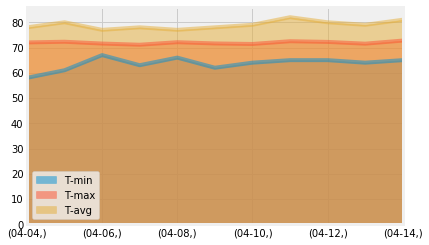

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.savefig("my_trip_normals")
fig.show()